<a href="https://colab.research.google.com/github/DianaShramchenko/data_mining/blob/main/%D0%9A_10%D0%BF%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №10. Анализ и сегментация клиентов с помощью алгоритмов кластеризации**

### **Цель работы:**

Разработать систему сегментации клиентов для розничной компании с использованием алгоритмов кластеризации. Это позволит компании лучше понимать своих клиентов, персонализировать маркетинговые кампании и оптимизировать бизнес-процессы.

### **Введение:**

Розничные компании сталкиваются с большим объемом данных о своих клиентах, включая историю покупок, демографическую информацию и поведенческие характеристики. Однако без должного анализа эти данные остаются неиспользованными. Сегментация клиентов позволяет выделить группы с общими характеристиками, чтобы более эффективно таргетировать предложения и улучшить удовлетворенность клиентов.



### **Задачи:**

1. **Сбор и анализ данных о клиентах.**
2. **Предобработка и подготовка данных для моделирования.**
3. **Применение различных алгоритмов кластеризации для сегментации клиентов.**
4. **Оценка качества кластеризации с использованием внутренних и внешних метрик.**
5. **Интерпретация и визуализация результатов.**
6. **Формирование рекомендаций для бизнес-стратегии компании на основе полученных сегментов.**



### **Пошаговое описание рабочего процесса (пайплайна):**

#### **Шаг 1: Сбор и анализ данных**

**1.1. Выбор набора данных:**

- Используйте датасет "Online Retail II" из [UCI Machine Learning Repository](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci) или другой открытый набор данных, содержащий информацию о транзакциях клиентов.
- Данные должны включать:
  - Идентификаторы клиентов.
  - Информацию о покупках (товары, количество, стоимость).
  - Дату и время транзакций.
  - Демографические данные (если доступны): возраст, пол, локация и т.д.

**1.2. Первичный анализ данных (EDA):**

- Изучите структуру данных и их распределение.
- Определите основные характеристики данных:
  - Общий объем продаж.
  - Частота покупок по клиентам.
  - Распределение выручки по товарам.
- Выявите тенденции и аномалии.

In [1]:
# Подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import os
from google.colab import drive

In [2]:
# Импортируем датасет
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_mining/10/online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Информация об атрибутах:

InvoiceNo: Номер счета-фактуры. Номинальный. 6-значное целое число, уникально назначаемое каждой транзакции. Если этот код начинается с буквы «c», это указывает на отмену.

StockCode: Код продукта (товара). Номинальный. 5-значное целое число, уникально назначаемое каждому отдельному продукту.

Description: Название продукта (товара). Номинальный.

Quantity: Количество каждого продукта (товара) за транзакцию. Числовой.

InvoiceDate: Дата и время выставления счета. Числовой. День и время, когда была создана транзакция.

UnitPrice: Цена за единицу. Числовой. Цена продукта за единицу в фунтах стерлингов (Â£).

CustomerID: Номер клиента. Номинальный. 5-значное целое число, уникально назначаемое каждому клиенту.

Country: Название страны. Номинальный. Название страны, в которой проживает клиент.

In [5]:
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# https://journal.sovcombank.ru/biznesu/kak-rasschitat-obem-prodazh#h_38591740811688451802644
# Общий объем продаж (в шт.)
print("Общий объем продаж с 2009 по 2011 года:", df['Quantity'].sum())
df['Year'] = df['InvoiceDate'].dt.year
quantity_year = df.groupby('Year')['Quantity'].sum()

for year, quantity in quantity_year.items():
    print(f"Общий объем продаж за {year} год: {quantity}")

Общий объем продаж с 2009 по 2011 года: 10608492
Общий объем продаж за 2009 год: 420088
Общий объем продаж за 2010 год: 5354181
Общий объем продаж за 2011 год: 4834223


In [8]:
# https://www.geckoboard.com/best-practice/kpi-examples/purchase-frequency/
# Частота покупок по клиентам
purchase_frequency = df['Customer ID'].value_counts()
print("Частота покупок (за весь период) по клиентам (топ 10):\n", purchase_frequency.head(10))

Частота покупок (за весь период) по клиентам (топ 10):
 Customer ID
17841.0    13097
14911.0    11613
12748.0     7307
14606.0     6709
14096.0     5128
15311.0     4717
14156.0     4130
14646.0     3890
13089.0     3438
16549.0     3255
Name: count, dtype: int64


In [9]:
# https://www.moedelo.org/club/article-knowledge/chto-takoe-vyruchka-i-kak-ee-rasschitat
# Распределение выручки по товарам
# выручка
df['Revenue'] = df['Quantity'] * df['Price']

revenue_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False)
print("Распределение выручки по товарам:\n", revenue_products.head(10))

Распределение выручки по товарам:
 Description
REGENCY CAKESTAND 3 TIER               327813.65
DOTCOM POSTAGE                         322647.47
WHITE HANGING HEART T-LIGHT HOLDER     257533.90
JUMBO BAG RED RETROSPOT                148800.64
PARTY BUNTING                          147948.50
ASSORTED COLOUR BIRD ORNAMENT          131413.85
PAPER CHAIN KIT 50'S CHRISTMAS         121662.14
POSTAGE                                112341.00
CHILLI LIGHTS                           84854.16
ROTATING SILVER ANGELS T-LIGHT HLDR     73814.72
Name: Revenue, dtype: float64


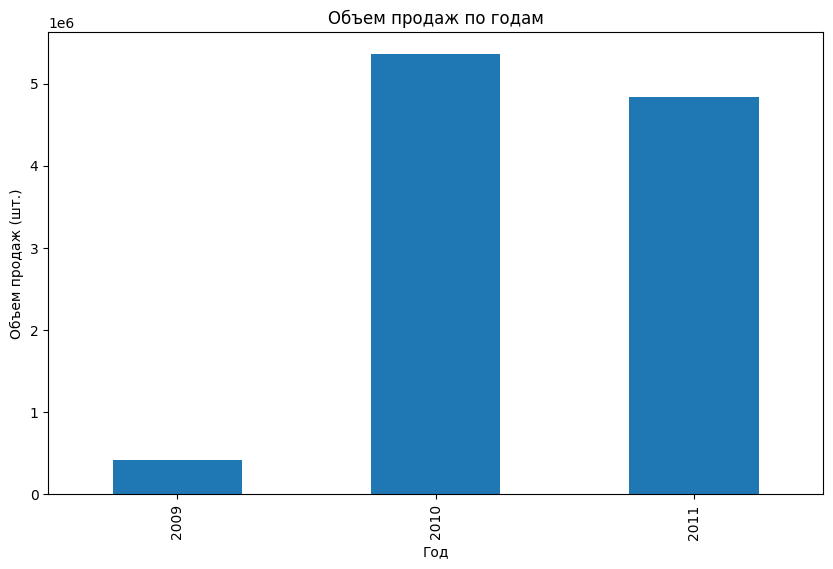

In [10]:
# Тенденции
plt.figure(figsize=(10, 6))
quantity_year.plot(kind='bar')
plt.title('Объем продаж по годам')
plt.xlabel('Год')
plt.ylabel('Объем продаж (шт.)')
plt.show()

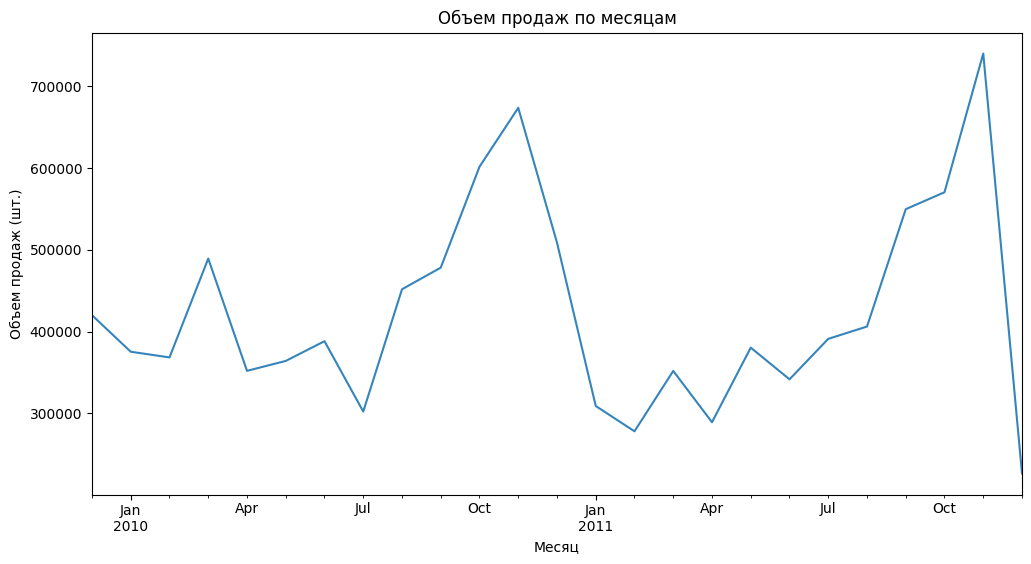

In [11]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
month_sales = df.groupby('Month')['Quantity'].sum()

plt.figure(figsize=(12, 6))
month_sales.plot(kind='line', alpha=0.9)
plt.title('Объем продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж (шт.)')
plt.show()

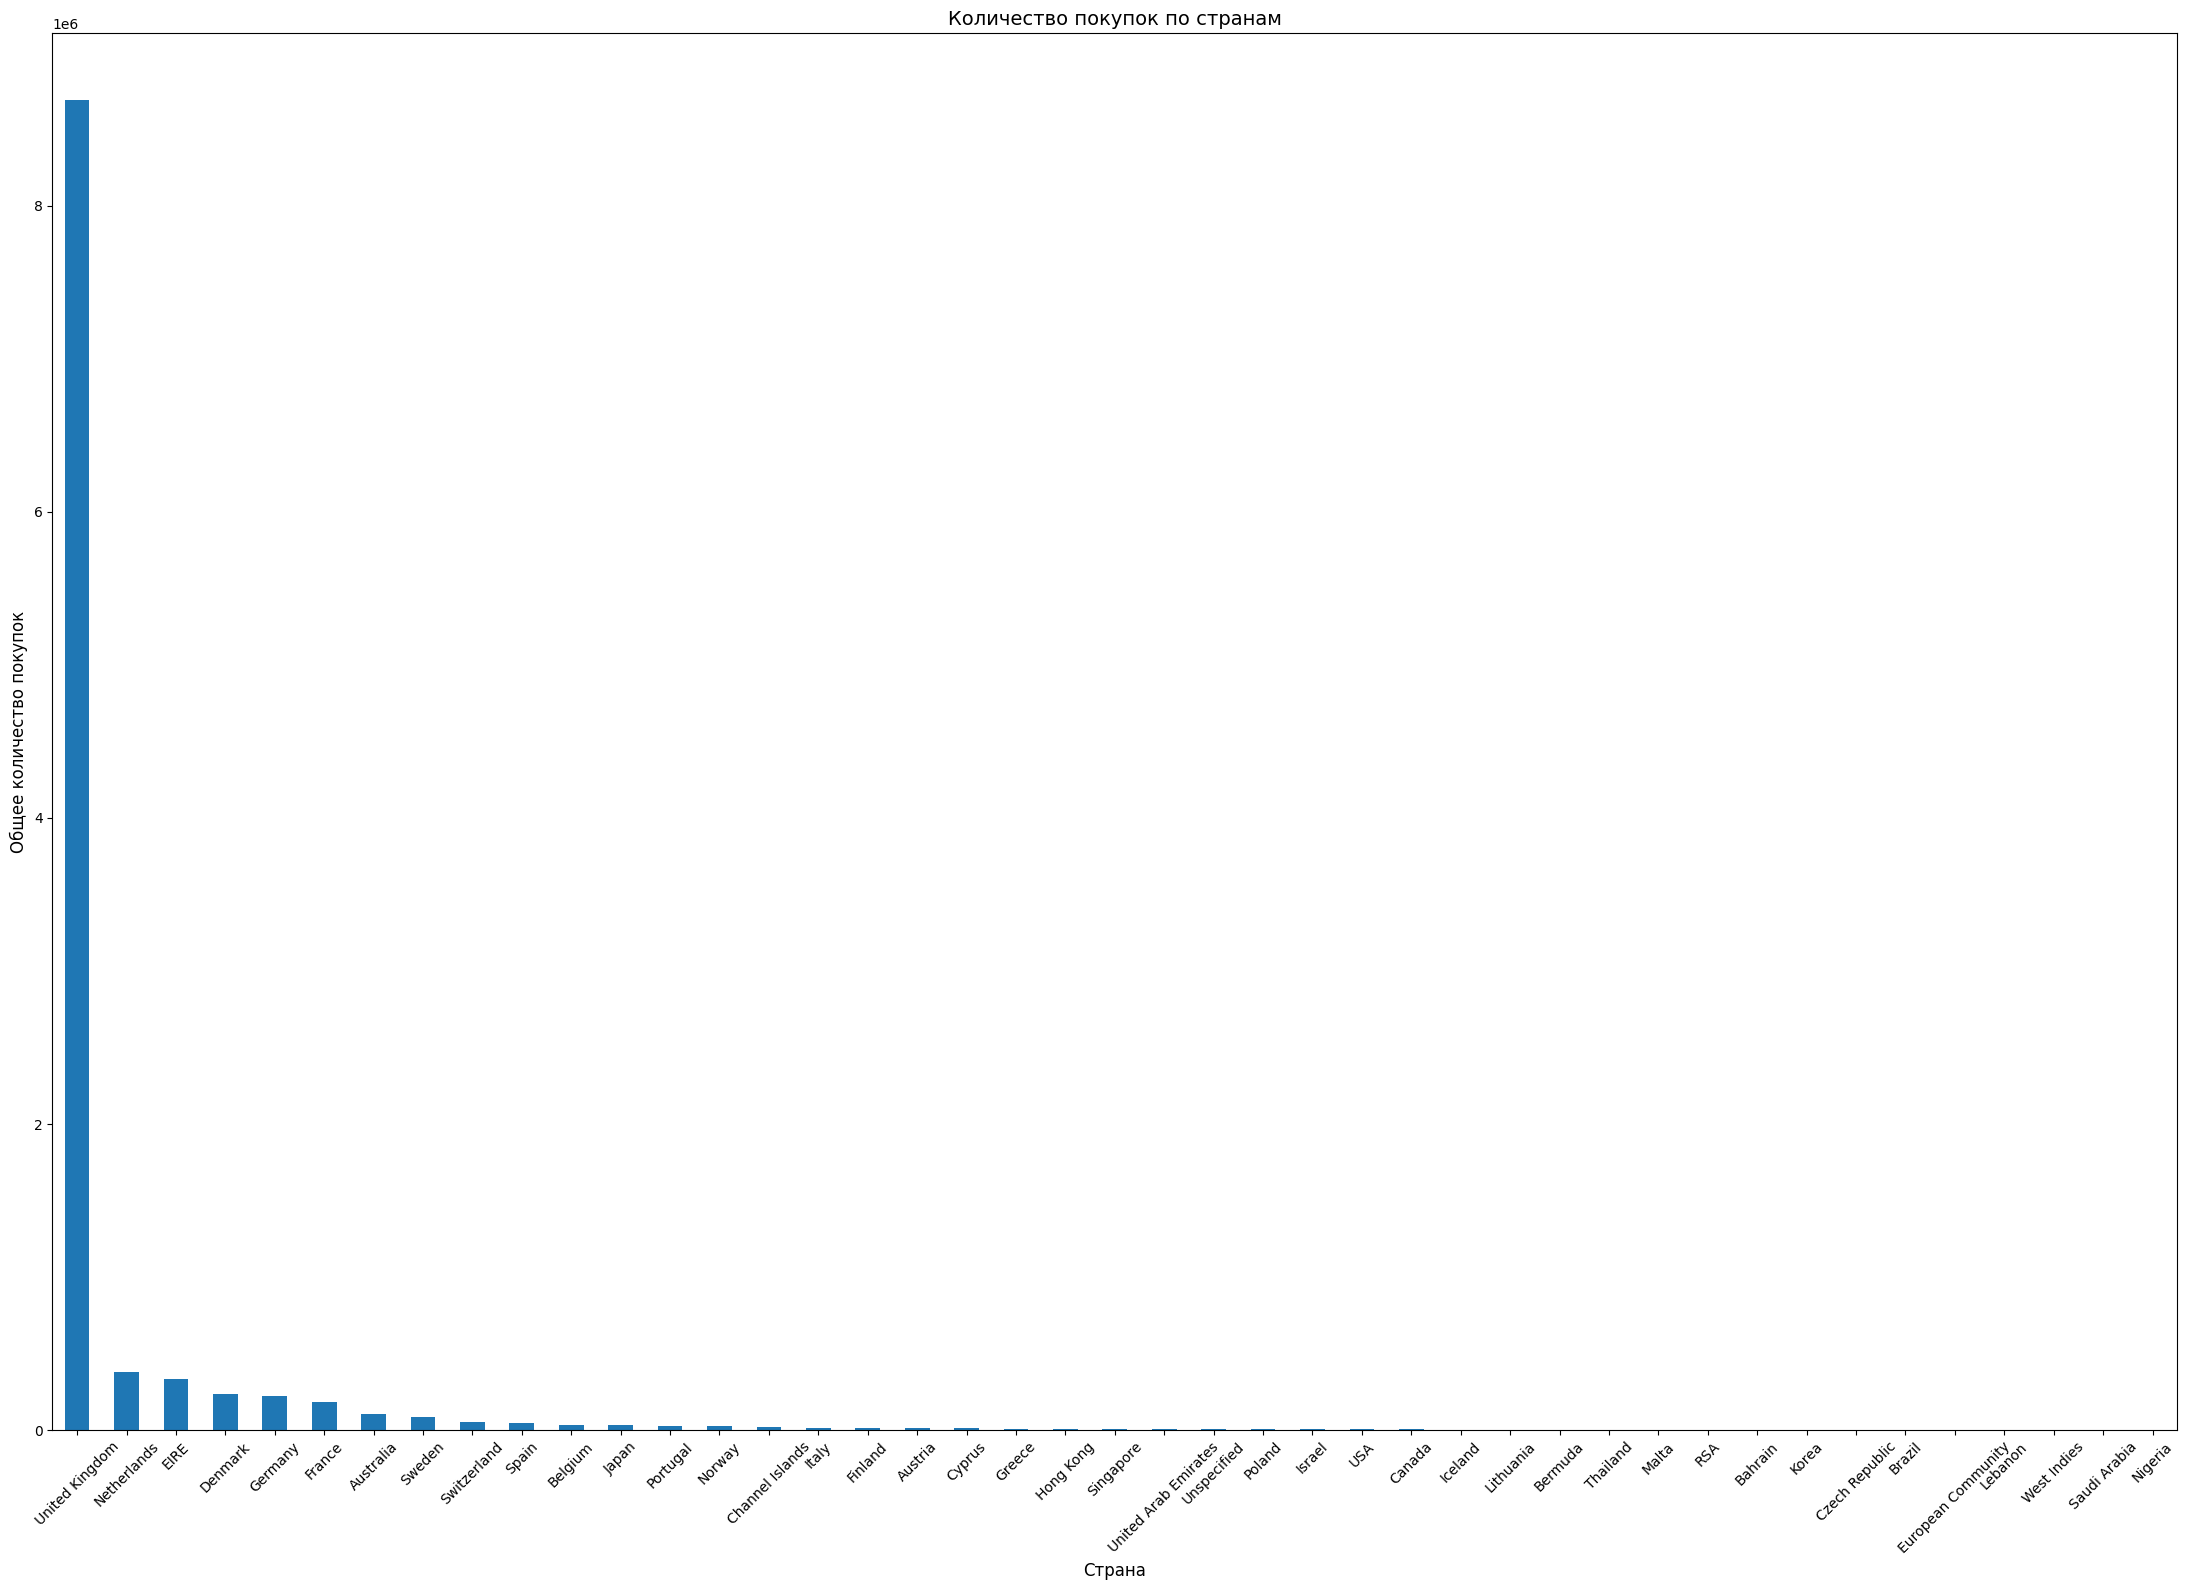

In [12]:
country = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)

plt.figure(figsize=(22, 16))
country.plot(kind='bar')
plt.title('Количество покупок по странам', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Общее количество покупок', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

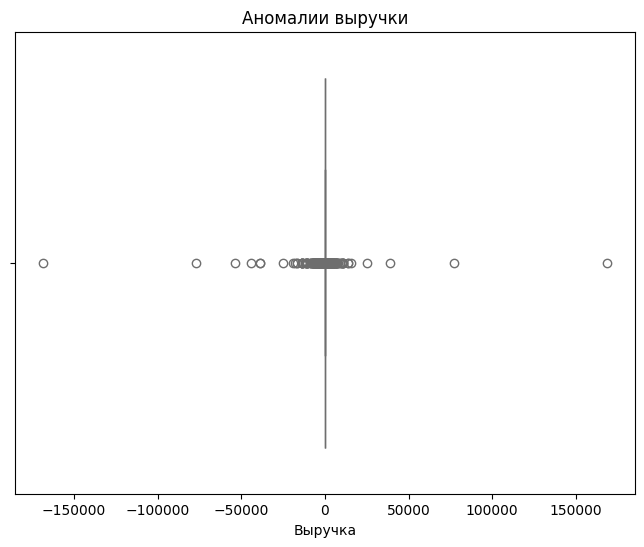

In [13]:
# Аномалии: boxplot для выручки
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Revenue'], color='lightcoral')
plt.title('Аномалии выручки')
plt.xlabel('Выручка')
plt.show()

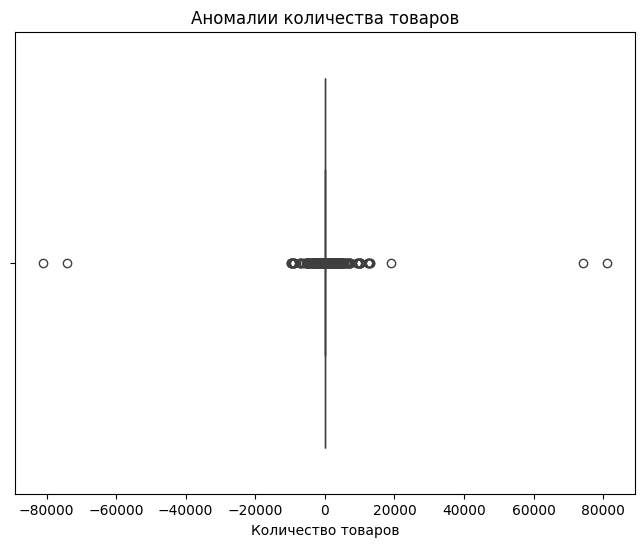

In [14]:
# Аномалии:кол-во товаров
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Quantity'])
plt.title('Аномалии количества товаров')
plt.xlabel('Количество товаров')
plt.show()

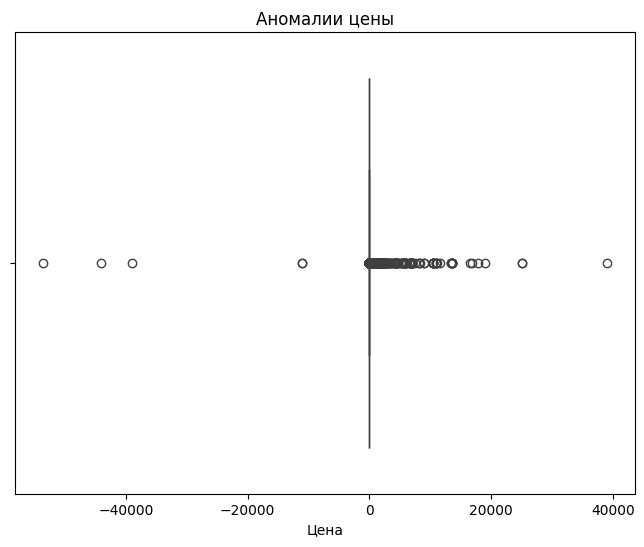

In [15]:
# Аномалии:цена
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Price'])
plt.title('Аномалии цены')
plt.xlabel('Цена')
plt.show()

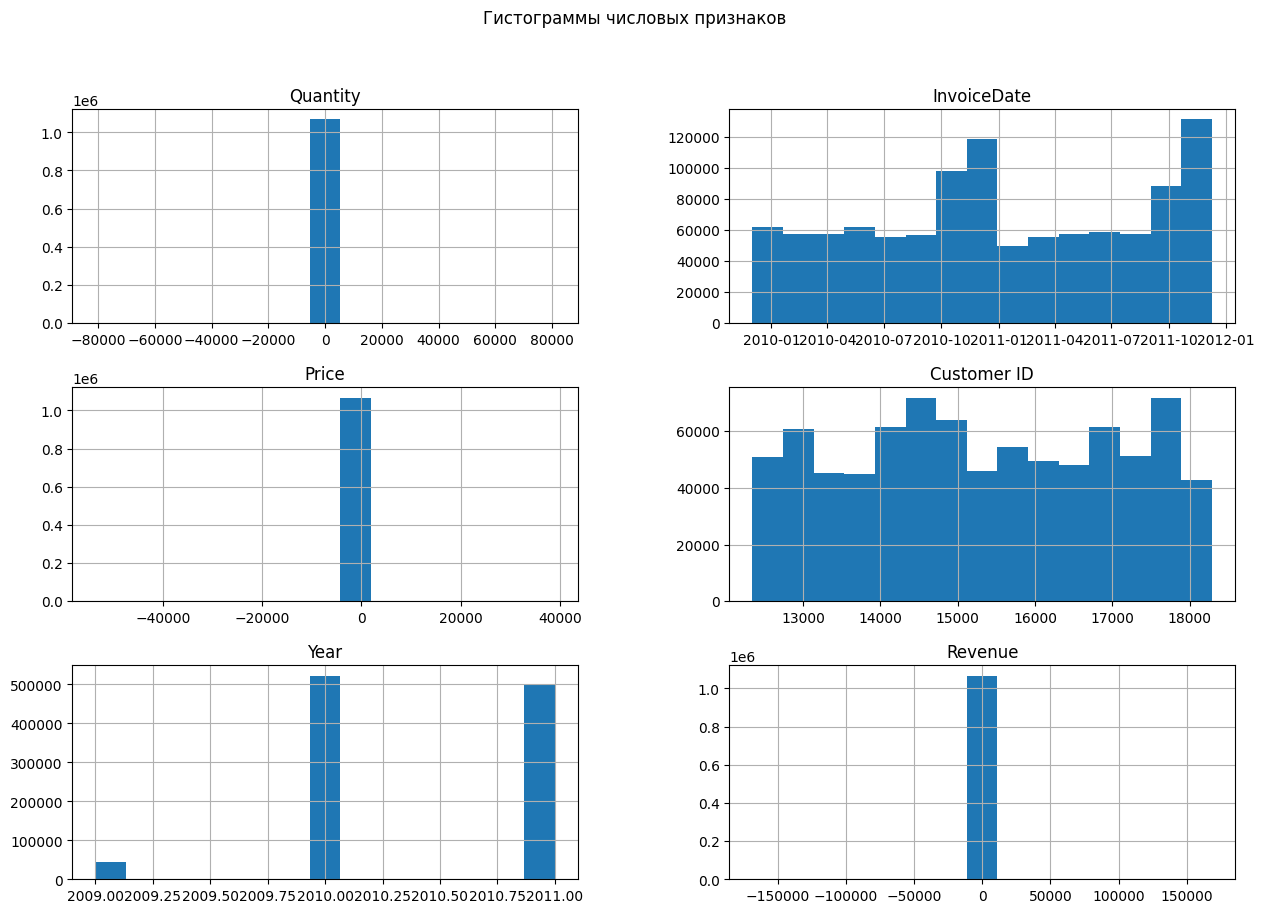

In [16]:
# Построение гистограмм для каждого числового признака
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков')
plt.show()

#### **Шаг 2: Предобработка данных**

**2.1. Работа с пропущенными значениями:**

- Проанализируйте наличие пропущенных данных.
- Решите, как справиться с ними:
  - Удаление строк/столбцов с пропущенными значениями.
  - Заполнение пропущенных значений средним, медианой или наиболее частым значением.

**2.2. Обработка выбросов:**

- Выявите выбросы в данных (например, аномально большие заказы).
- Решите, следует ли их удалить или обработать иным образом.

**2.3. Создание новых признаков:**

- Рассчитайте Recency, Frequency, Monetary Value (RFM-анализ):
  - **Recency (давность):** Время с момента последней покупки.
  - **Frequency (частота):** Количество покупок за определенный период.
  - **Monetary (сумма):** Общая сумма покупок.
- Создайте дополнительные признаки, такие как средний чек, предпочтительные категории товаров и т.д.

**2.4. Нормализация и масштабирование:**

- Примените стандартизацию или нормализацию к числовым признакам для приведения их к единому масштабу.
- Объясните выбор метода масштабирования.

In [17]:
# Удаление строк с пропусками в столбце Description
df = df.dropna(subset=['Description'])

In [18]:
# Заполнение пропусков в столбце 'Customer ID' значением
df.loc[df['Customer ID'].isnull(), 'Customer ID'] = np.random.randint(10000, 99999, size=df['Customer ID'].isnull().sum())

In [19]:
print(df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Year           0
Revenue        0
Month          0
dtype: int64


In [20]:
# Удаление выбросов
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df = df[df['Revenue'] > 0]

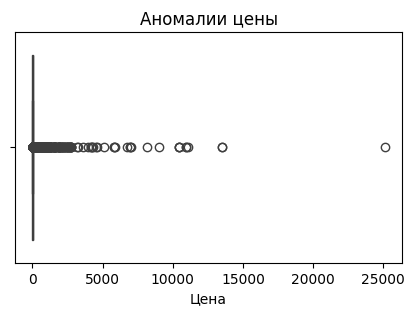

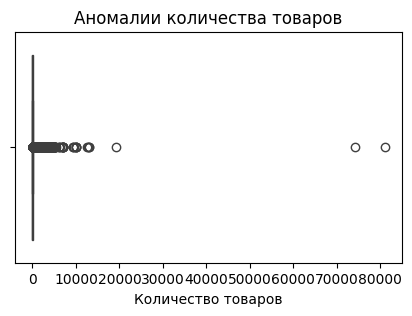

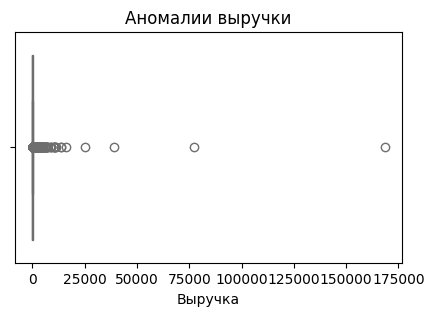

In [21]:
# проверка
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['Price'])
plt.title('Аномалии цены')
plt.xlabel('Цена')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x=df['Quantity'])
plt.title('Аномалии количества товаров')
plt.xlabel('Количество товаров')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x=df['Revenue'], color='lightcoral')
plt.title('Аномалии выручки')
plt.xlabel('Выручка')
plt.show()

In [22]:
import datetime as dt

In [23]:
# https://www.mango-office.ru/products/calltracking/for-marketing/osnovy/chto-takoe-rfm-analiz-i-kak-ego-provesti/
# https://habr.com/ru/companies/otus/articles/666862/

# Исключение строк с отрицательными значениями Revenue
df = df[df['Revenue'] > 0]

# Пересчет RFM-таблицы
RFM_data = df[['Customer ID', 'Invoice', 'InvoiceDate', 'Revenue']]

# Последняя дата
NOW = dt.datetime(2011, 12, 10)

RFM_table = RFM_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency (давность)
    'Invoice': lambda x: x.nunique(),  # Frequency (частота)
    'Revenue': lambda x: x.sum()       # Monetary (сумма)
})

# Приведение столбца Recency к целочисленному типу
RFM_table['InvoiceDate'] = RFM_table['InvoiceDate'].astype(int)

# Переименовываем столбцы
RFM_table.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# Проверка на отрицательные значения
negative_values = RFM_table[(RFM_table['Recency'] < 0) | (RFM_table['Frequency'] < 0) | (RFM_table['Monetary'] < 0)]

if negative_values.empty:
    print("Проверка завершена: отрицательных значений в RFM-таблице нет.")
else:
    print("Обнаружены отрицательные значения:")
    print(negative_values)

# Вывод первых строк RFM-таблицы
print(RFM_table.head(10))

Проверка завершена: отрицательных значений в RFM-таблице нет.
             Recency  Frequency  Monetary
Customer ID                              
10000.0           28          7     87.77
10001.0           11          1      0.83
10002.0          184          4      9.91
10003.0          462          2     18.37
10004.0            3          5      9.93
10005.0          114          4     37.20
10006.0          477          1      3.36
10007.0           98          2     42.89
10008.0           67          3     19.96
10009.0            0          4     19.74


In [24]:
# Доп. признаки
# Средний чек
RFM_table['average_bill'] = RFM_table['Monetary'] / RFM_table['Frequency']

# Предпочтительные категории товаров
preferred_categories = df.groupby(['Customer ID', 'Description'])['Quantity'].sum().reset_index()
preferred_categories = preferred_categories.loc[
    preferred_categories.groupby('Customer ID')['Quantity'].idxmax()
]
preferred_categories = preferred_categories.rename(columns={'Description': 'preferred_category'})

# Объединение предпочтительных категорий с RFM таблицей
RFM_table = RFM_table.merge(preferred_categories[['Customer ID', 'preferred_category']], on='Customer ID', how='left')

In [25]:
RFM_table.head(10)

,Customer ID,Recency,Frequency,Monetary,average_bill,preferred_category
0,10000.0,28,7,87.77,12.538571,PAPER CHAIN KIT VINTAGE CHRISTMAS
1,10001.0,11,1,0.83,0.830000,SET 12 KIDS COLOUR CHALK STICKS
2,10002.0,184,4,9.91,2.477500,BIRTHDAY PARTY CORDON BARRIER TAPE
3,10003.0,462,2,18.37,9.185000,WATERMELON BATH SPONGE
4,10004.0,3,5,9.93,1.986000,BLUE POLKADOT CUP
5,10005.0,114,4,37.20,9.300000,DOOR MAT RED SPOT
6,10006.0,477,1,3.36,3.360000,SUKI SHOULDER BAG
7,10007.0,98,2,42.89,21.445000,WOOD 2 DRAWER CABINET WHITE FINISH
8,10008.0,67,3,19.96,6.653333,SET 6 PAPER TABLE LANTERN HEARTS
9,10009.0,0,4,19.74,4.935000,"BIRTHDAY CARD, RETRO SPOT"


In [26]:
# Объединяем данные с исходной таблицей
df = df.merge(RFM_table, on='Customer ID', how='left')
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Revenue,Month,Recency,Frequency,Monetary,average_bill,preferred_category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,83.4,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,81.0,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,81.0,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,100.8,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,30.0,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,2009,39.6,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,30.0,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,2009,59.5,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,2009,30.6,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,2009,45.0,2009-12,0,14,2474.87,176.776429,"RECORD FRAME 7"" SINGLE SIZE"


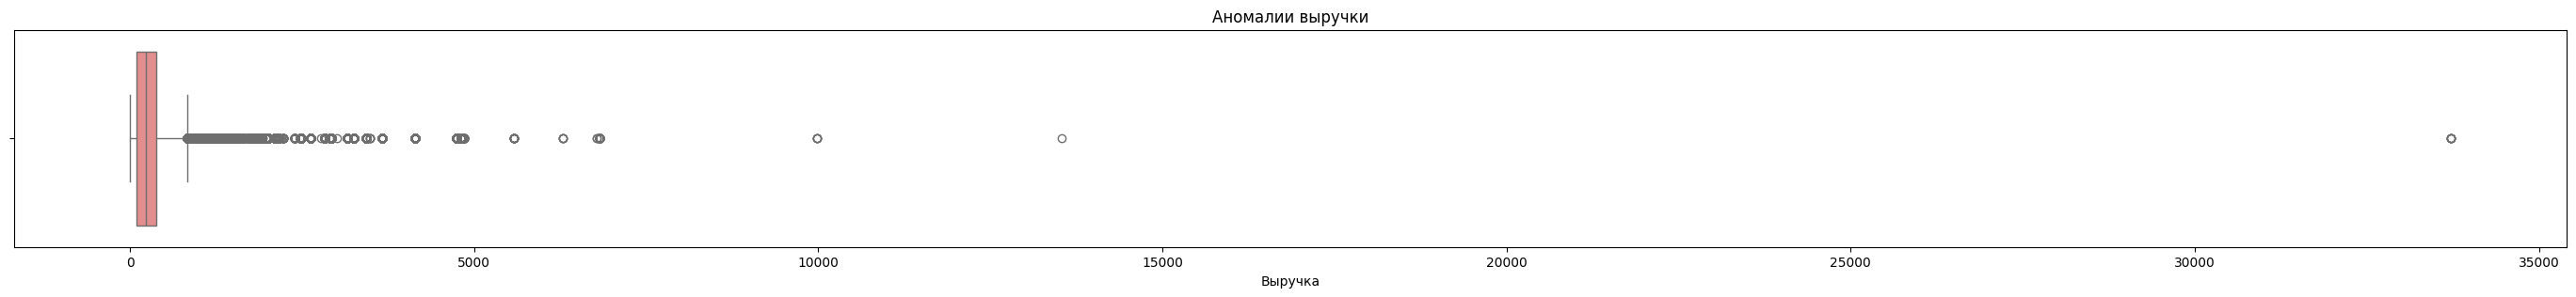

In [27]:
plt.figure(figsize=(35, 3))
sns.boxplot(x=df['average_bill'], color='lightcoral')
plt.title('Аномалии выручки')
plt.xlabel('Выручка')
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
# Стандартизация признаков
features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

#### **Шаг 3: Применение алгоритмов кластеризации**

**3.1. Выбор алгоритмов:**

- **K-средних (K-Means):** Для разбиения данных на k кластеров на основе эврестического подхода.
- **Иерархическая кластеризация:** Для выявления вложенной структуры кластеров.
- **DBSCAN и OPTICS:** Для обнаружения кластеров произвольной формы и выявления выбросов.

**3.2. Определение оптимального количества кластеров:**

- Для K-Means и иерархической кластеризации используйте:
  - **Метод локтя (Elbow Method):** Постройте график зависимости суммы квадратов внутрикластерных расстояний от числа кластеров.
  - **Коэффициент силуэта:** Рассчитайте для различных значений k и выберите оптимальное.

**3.3. Применение алгоритмов:**

- Запустите каждый алгоритм на подготовленных данных.
- Сохраняйте результаты кластеризации для последующего анализа.

In [30]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt


In [31]:
X = df[features]

In [32]:
# Диапазон чисел кластеров для анализа
K = range(1, 11)

In [33]:
# Метод локтя (Elbow Method)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [34]:
# Определение оптимального K по методу локтя
diff_inertia = np.diff(inertia)
diff_diff_inertia = np.diff(diff_inertia)
elbow_point = np.argmin(diff_diff_inertia) + 2  # +2 из-за порядка дифференцирования

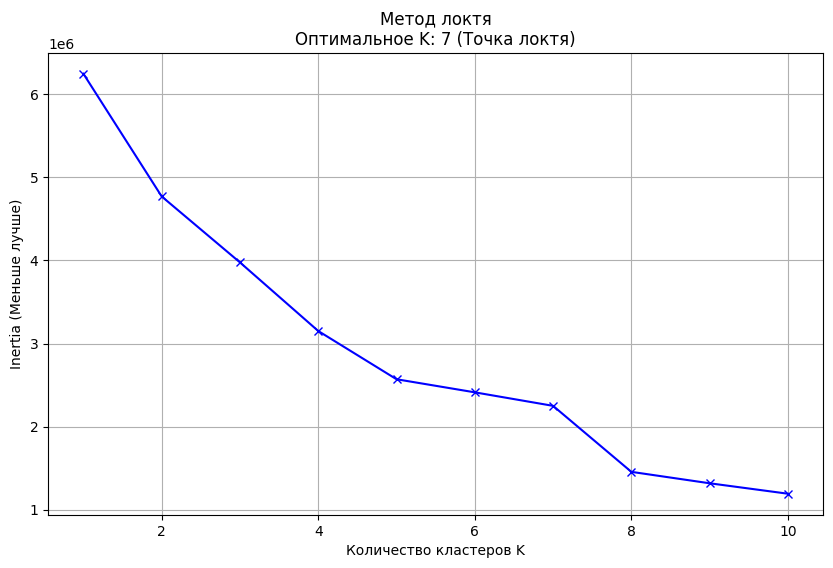

In [35]:
# График 1: Метод локтя
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Количество кластеров K')
plt.ylabel('Inertia (Меньше лучше)')
plt.title(f'Метод локтя\nОптимальное K: {elbow_point} (Точка локтя)')
plt.grid(True)
plt.show()

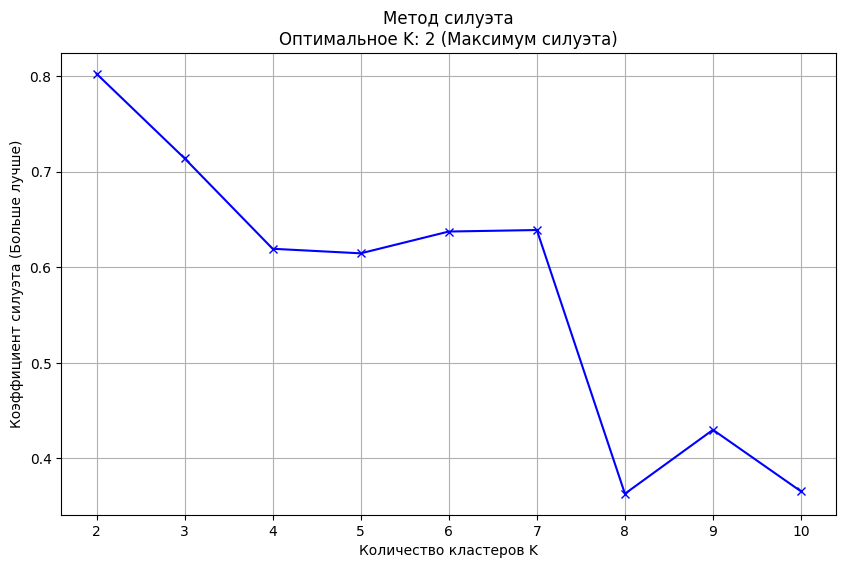

In [36]:
# Метод силуэта (Silhouette Method)
from sklearn.utils import resample

# Случайная подвыборка данных
X_sampled = resample(X, n_samples=30000, random_state=42)  # Укажите нужный размер
silhouette_scores = []
K_silhouette = range(2, 11)  # Силуэт не определяется для k=1
for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sampled)
    score = silhouette_score(X_sampled, labels)
    silhouette_scores.append(score)

# Определение оптимального K по методу силуэта
optimal_k_silhouette = K_silhouette[np.argmax(silhouette_scores)]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(K_silhouette, silhouette_scores, 'bx-')
plt.xlabel('Количество кластеров K')
plt.ylabel('Коэффициент силуэта (Больше лучше)')
plt.title(f'Метод силуэта\nОптимальное K: {optimal_k_silhouette} (Максимум силуэта)')
plt.grid(True)
plt.show()

In [37]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Случайная выборка строк из датафрейма
df_sampled = df.sample(n=30000, random_state=42)
# Извлечение признаков для кластеризации
features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
X_sampled = df_sampled[features]

In [39]:
# K-средних (K-Means)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
kmeans_labels = kmeans.fit_predict(X_sampled)

# Сохранение результатов кластеризации в файл на Google Диске
file_path_1 = '/content/drive/MyDrive/data_mining/10/kmeans_2.xlsx'  # Укажите нужный путь
df_sampled.to_excel(file_path_1, index=False)

print(f"Результаты кластеризации сохранены в {file_path_1}")

Результаты кластеризации сохранены в /content/drive/MyDrive/data_mining/10/kmeans_2.xlsx


In [40]:
# Иерархическая кластеризация
n_clusters = 6  # Оптимальное количество кластеров из метода локтя
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_sampled)

# Добавление меток кластеров в исходный DataFrame
df_sampled['hierarchical_cluster'] = hierarchical_labels

# Сохранение результатов кластеризации в файл на Google Диске
file_path_2 = '/content/drive/MyDrive/data_mining/10/hierarchical_2.xlsx'  # Укажите нужный путь
df_sampled.to_excel(file_path_2, index=False)

print(f"Результаты кластеризации сохранены в {file_path_2}")

Результаты кластеризации сохранены в /content/drive/MyDrive/data_mining/10/hierarchical_2.xlsx


In [41]:
# Инициализация DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Параметры eps и min_samples подбираются в зависимости от задачи

# Применение DBSCAN
dbscan_labels = dbscan.fit_predict(X_sampled)

# Добавление меток кластеров в DataFrame
df_sampled['dbscan_cluster'] = dbscan_labels

# Сохранение результатов кластеризации в файл на Google Диске
file_path_3 = '/content/drive/MyDrive/data_mining/10/dbscan_2.xlsx'  # Укажите нужный путь
df_sampled.to_excel(file_path_3, index=False)

print(f"Результаты кластеризации с DBSCAN для случайной выборки сохранены в {file_path_3}")

Результаты кластеризации с DBSCAN для случайной выборки сохранены в /content/drive/MyDrive/data_mining/10/dbscan_2.xlsx


In [42]:
# Инициализация OPTICS
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)

# Применение OPTICS
optics_labels = optics.fit_predict(X_sampled)

# Добавление меток кластеров в DataFrame
df_sampled['optics_cluster'] = optics_labels

# Сохранение результатов кластеризации в файл на Google Диске
file_path_4 = '/content/drive/MyDrive/data_mining/10/optics.xlsx'  # Укажите нужный путь
df_sampled.to_excel(file_path_4, index=False)

print(f"Результаты кластеризации с OPTICS для случайной выборки сохранены в {file_path_4}")

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Результаты кластеризации с OPTICS для случайной выборки сохранены в /content/drive/MyDrive/data_mining/10/optics.xlsx


#### **Шаг 4: Оценка качества кластеризации**

**4.1. Внутренние метрики:**

- **Коэффициент силуэта:** Оцените, насколько хорошо объекты расположены внутри кластеров.
- **Индекс Дэвиса-Болдина:** Оцените уровень разделимости кластеров.
- **Индекс Калинского-Харабаза:** Оцените соотношение межкластерной дисперсии к внутрикластерной.

**4.2. Внешние метрики (если доступны истинные метки):**

- **Adjusted Rand Index (ARI):** Сравните полученные кластеры с известными категориями клиентов.
- **Normalized Mutual Information (NMI):** Измерьте общую информацию между распределениями.

**4.3. Сравнение алгоритмов:**

- Составьте таблицу со значениями метрик для каждого алгоритма.
- Определите, какой алгоритм показал наилучшие результаты и почему.

In [43]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score
)
from scipy.spatial.distance import cdist, pdist

In [44]:
# Функция для вычисления индекса Дунна
def dunn_index(X, labels):
    labels = np.array(labels)
    mask = labels != -1  # исключаем шумовые точки
    X = X[mask]
    labels = labels[mask]

    unique_clusters = np.unique(labels)
    clusters = [X[labels == label] for label in unique_clusters]

    # Межкластерные расстояния
    min_intercluster = np.inf
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = np.min(cdist(clusters[i], clusters[j]))
            if dist < min_intercluster:
                min_intercluster = dist

    # Внутрикластерные расстояния
    max_intracluster = 0
    for cluster in clusters:
        if len(cluster) > 1:
            dist = np.max(pdist(cluster))
            if dist > max_intracluster:
                max_intracluster = dist

    if max_intracluster == 0 or np.isinf(min_intercluster):
        return np.nan
    else:
        return min_intercluster / max_intracluster

# Функция для расчета внутренних метрик
def compute_internal_metrics(X, labels):
    mask = labels != -1  # исключаем шумовые точки
    X_masked = X[mask]
    labels_masked = labels[mask]
    if len(np.unique(labels_masked)) > 1 and len(X_masked) > 0:
        silhouette = silhouette_score(X_masked, labels_masked)
        calinski_harabasz = calinski_harabasz_score(X_masked, labels_masked)
        davies_bouldin = davies_bouldin_score(X_masked, labels_masked)
        dunn = dunn_index(X, labels)
    else:
        silhouette = np.nan
        calinski_harabasz = np.nan
        davies_bouldin = np.nan
        dunn = np.nan
    return {
        'Коэффициент силуэта': silhouette,
        'Индекс Дэвиса-Болдина': davies_bouldin,
        'Индекс Калинского-Харабаза': calinski_harabasz,
        'Индекс Дунна': dunn
    }

# Функция для расчета внешних метрик
def compute_external_metrics(y_true, y_pred):
    mask = y_pred != -1  # исключаем шумовые точки
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    if len(np.unique(y_pred_masked)) > 1 and len(y_true_masked) > 0:
        ari = adjusted_rand_score(y_true_masked, y_pred_masked)
        v_measure = v_measure_score(y_true_masked, y_pred_masked)
        nmi = normalized_mutual_info_score(y_true_masked, y_pred_masked)
    else:
        ari = np.nan
        v_measure = np.nan
        nmi = np.nan
    return {
        'Adjusted Rand Index (ARI)': ari,
        'V-measure': v_measure,
        'Normalized Mutual Information (NMI)': nmi
    }

In [45]:
metrics_results = {}

# Внутренние метрики
metrics_results['KMeans'] = compute_internal_metrics(X_sampled, kmeans_labels)
metrics_results['DBSCAN'] = compute_internal_metrics(X_sampled, dbscan_labels)
#metrics_results['OPTICS'] = compute_internal_metrics(X_sampled, optics_labels)
metrics_results['Hierarchical'] = compute_internal_metrics(X_sampled, hierarchical_labels)

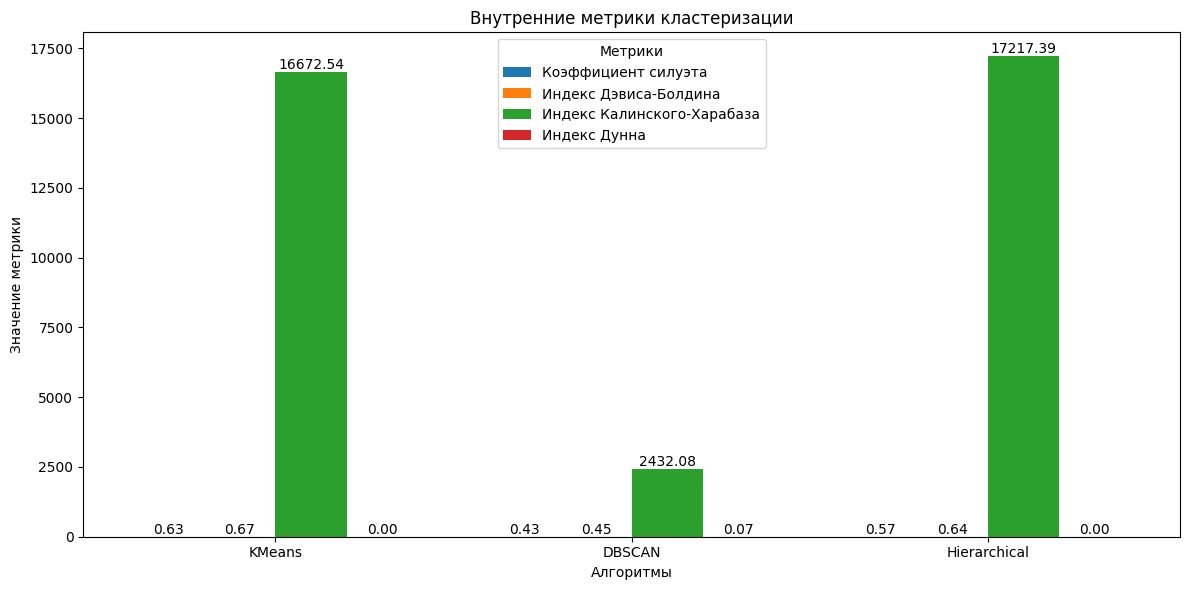

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Алгоритмы и метрики для визуализации
algorithms = list(metrics_results.keys())
internal_metrics = list(metrics_results[algorithms[0]].keys())

# Подготовка данных
def collect_internal_metrics(metrics_results, internal_metrics):
    data = {metric: [metrics_results[algo][metric] for algo in algorithms] for metric in internal_metrics}
    return data

internal_data = collect_internal_metrics(metrics_results, internal_metrics)

# Функция для построения графиков
def plot_internal_metrics(data, algorithms, title):
    x = np.arange(len(algorithms))  # позиции для алгоритмов
    width = 0.2  # ширина одного столбца
    offsets = np.arange(len(data)) * width - (len(data) - 1) * width / 2

    plt.figure(figsize=(12, 6))
    for idx, (metric, values) in enumerate(data.items()):
        plt.bar(x + offsets[idx], values, width, label=metric)
        # Добавление меток над столбцами
        for xi, value in zip(x, values):
            if not np.isnan(value):
                plt.text(xi + offsets[idx], value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    # Настройка осей и легенды
    plt.xticks(x, algorithms)
    plt.xlabel('Алгоритмы')
    plt.ylabel('Значение метрики')
    plt.title(title)
    plt.legend(title="Метрики")
    plt.tight_layout()
    plt.show()

# Построение графика
plot_internal_metrics(internal_data, algorithms, "Внутренние метрики кластеризации")

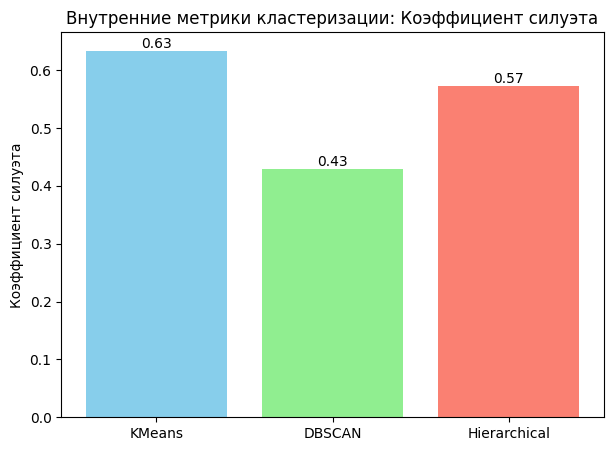

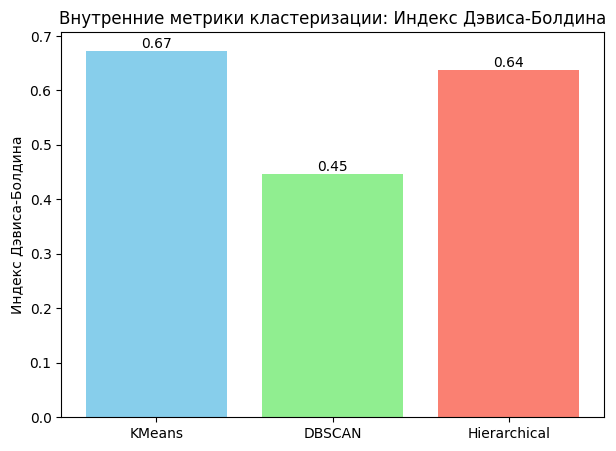

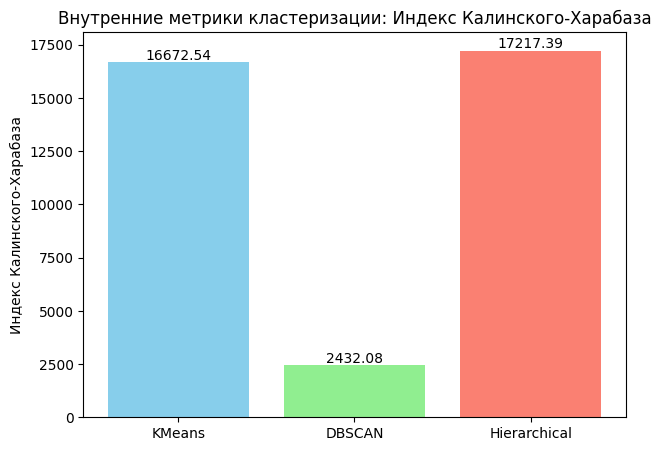

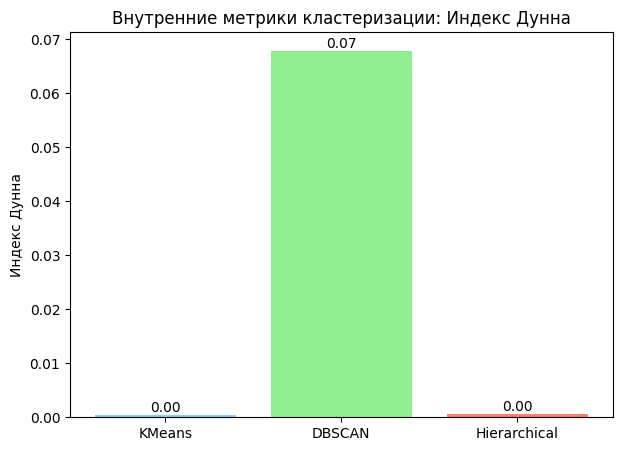

In [47]:
# Визуализация метрик
def plot_metrics(metrics, title):
    algorithms = list(metrics.keys())
    metrics_names = list(metrics[algorithms[0]].keys())

    # Список цветов для каждого алгоритма
    colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral']

    for metric in metrics_names:
        values = [metrics[algo][metric] for algo in algorithms]
        plt.figure(figsize=(7, 5))

        # Используем список цветов для каждого столбца
        plt.bar(algorithms, values, color=colors[:len(algorithms)])

        # Добавление меток над столбцами
        for i, value in enumerate(values):
            if not np.isnan(value):
                plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

        plt.title(f"{title}: {metric}")
        plt.ylabel(metric)
        plt.show()

# Построение графиков для внутренних метрик
plot_metrics(metrics_results, 'Внутренние метрики кластеризации')

#### **Шаг 5: Интерпретация и визуализация результатов**

**5.1. Визуализация кластеров:**

- **Снижение размерности:** Примените PCA или t-SNE для отображения данных в 2D или 3D пространстве.
- **Постройте графики:**
  - Рассеивания с цветовой кодировкой кластеров.
  - Дендрограммы для иерархической кластеризации.
- **Визуализация признаков:**
  - Постройте боксплоты, гистограммы или тепловые карты для сравнения признаков между кластерами.

**5.2. Описание сегментов:**

- Для каждого кластера опишите характерные черты:
  - Средние значения признаков.
  - Поведенческие особенности (например, частота покупок, средний чек).
  - Демографические характеристики (если доступны).
- Присвойте сегментам осмысленные названия (например, "Лояльные клиенты", "Покупатели со сниженной активностью", "Большие транзакции").

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [49]:
# Снижение размерности (PCA или t-SNE)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

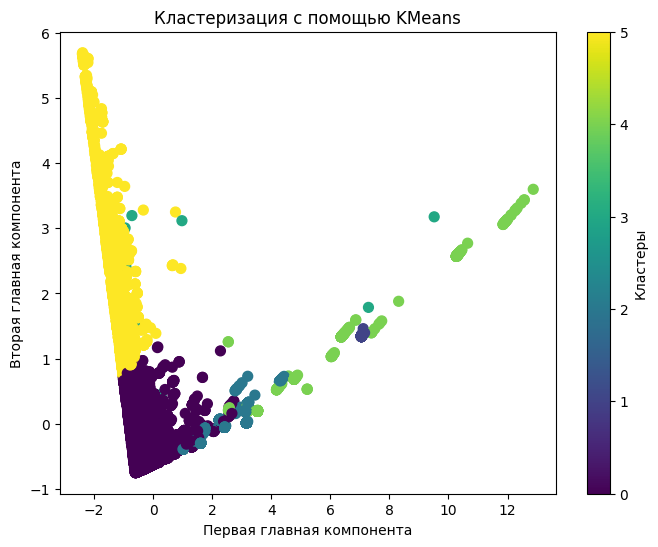

In [50]:
# 1. Визуализация кластеров с цветовой кодировкой (рассеяние)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('Кластеризация с помощью KMeans')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Кластеры')
plt.show()

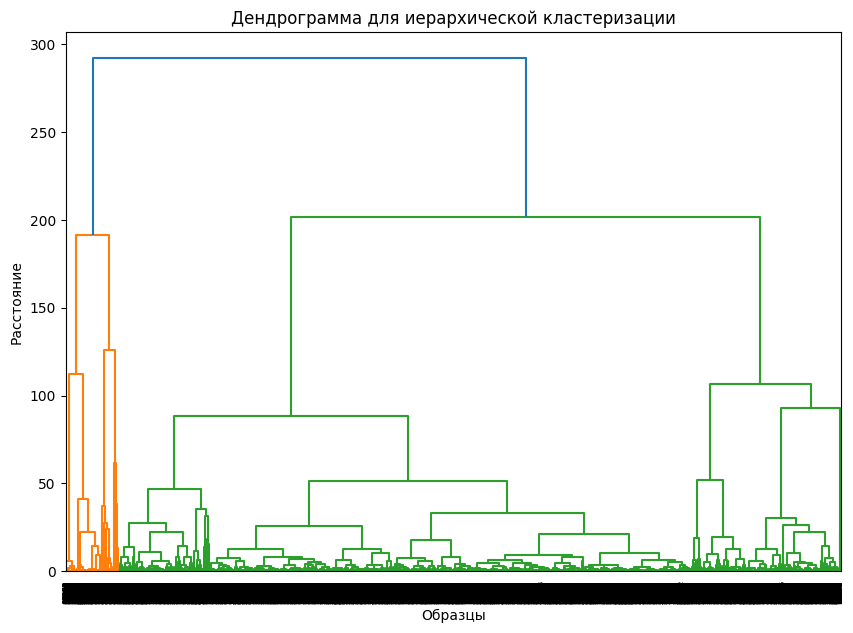

In [51]:
# 2. Дендрограмма для иерархической кластеризации
linked = linkage(X_sampled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Дендрограмма для иерархической кластеризации')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.show()

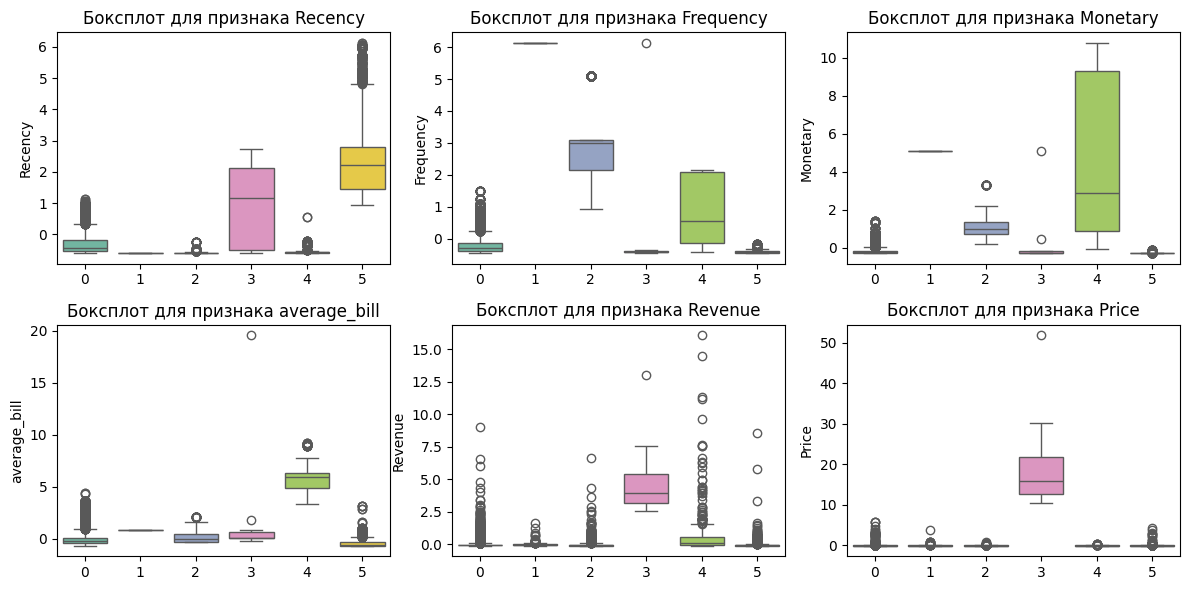

In [63]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=kmeans_labels, y=X_sampled[feature], hue=kmeans_labels, palette='Set2', legend=False)
    plt.title(f'Боксплот для признака {feature}')
plt.tight_layout()
plt.show()

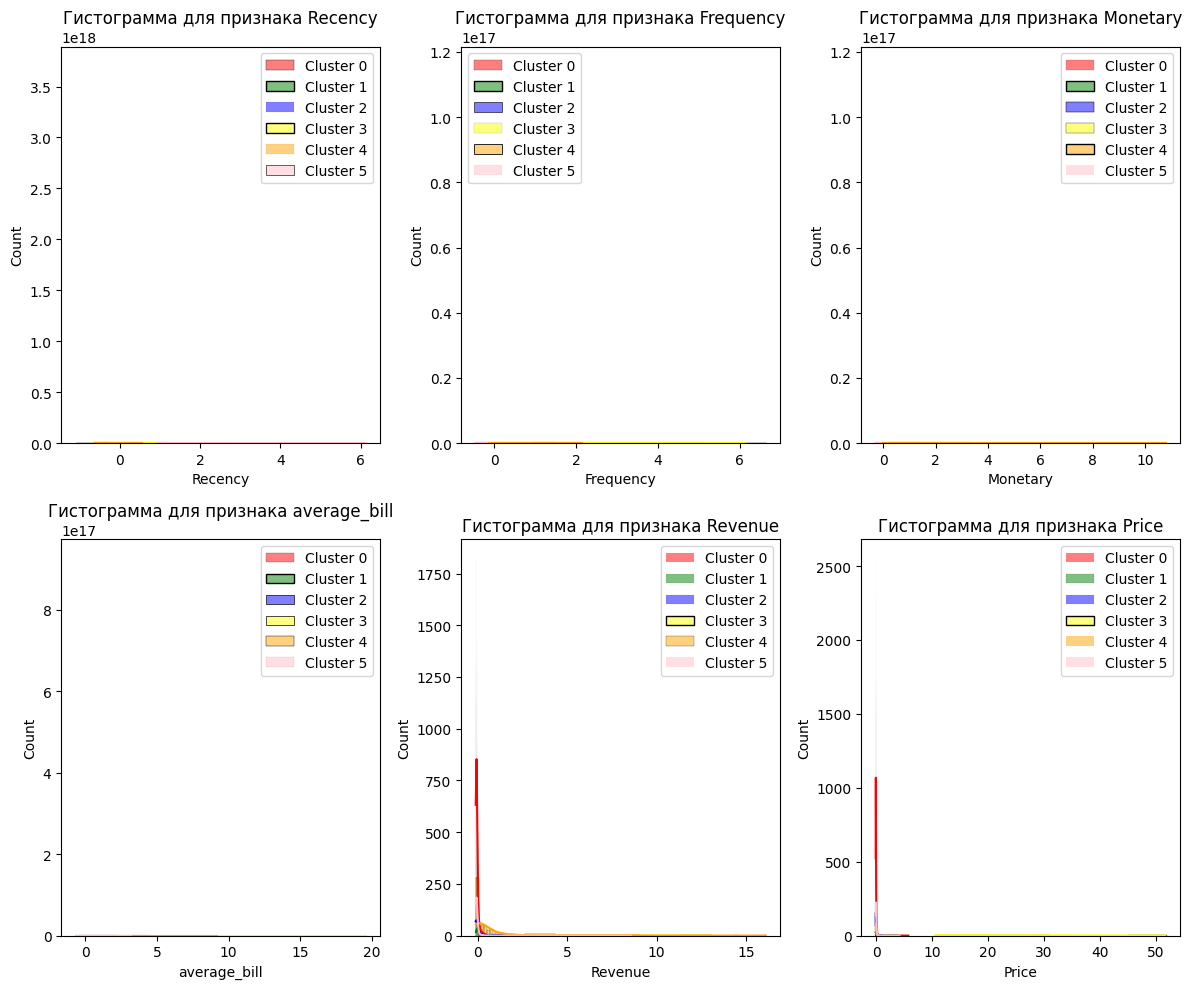

In [53]:
# 4. Гистограммы для признаков между кластерами
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(X_sampled[feature][kmeans_labels == 0], color='red', label='Cluster 0', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 1], color='green', label='Cluster 1', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 2], color='blue', label='Cluster 2', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 3], color='yellow', label='Cluster 3', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 4], color='orange', label='Cluster 4', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 5], color='pink', label='Cluster 5', kde=True)
    plt.title(f'Гистограмма для признака {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

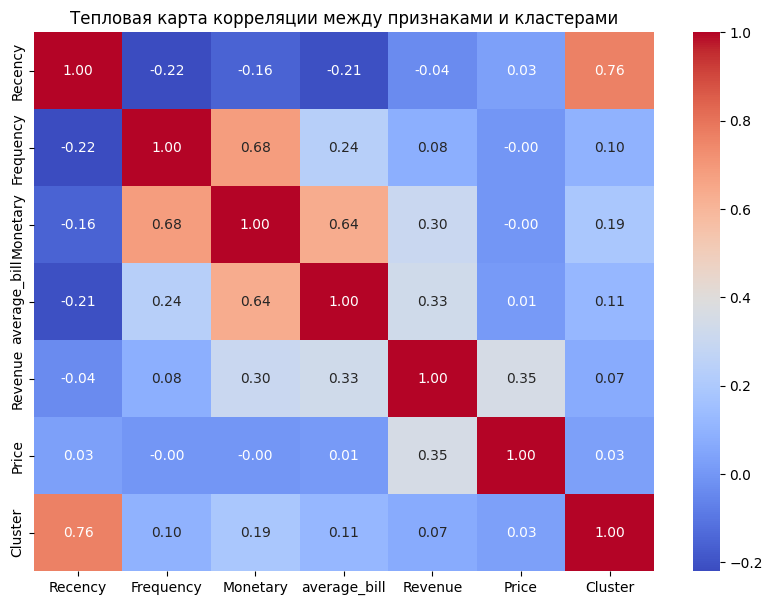

In [54]:
# 5. Тепловая карта для корреляции признаков между кластерами
df_sampled = pd.DataFrame(X_sampled, columns=features)
df_sampled['Cluster'] = kmeans_labels

plt.figure(figsize=(10, 7))
correlation_matrix = df_sampled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Тепловая карта корреляции между признаками и кластерами')
plt.show()

In [57]:
import pandas as pd
# Добавление столбцов Description и preferred_category из исходного датафрейма в df_sampled
df_sampled['Description'] = df['Description']
df_sampled['preferred_category'] = df['preferred_category']
# Добавляем метки кластеров K-Means к датафрейму
df_sampled['kmeans_cluster'] = kmeans_labels

# Функция для описания сегментов
def describe_kmeans_clusters(df, features, cluster_column):
    # Рассчитываем средние значения признаков для каждого кластера
    cluster_description = df.groupby(cluster_column)[features].mean()

    # Добавляем дополнительные поведенческие характеристики
    cluster_description['Средняя частота покупок'] = df.groupby(cluster_column)['Frequency'].mean()
    cluster_description['Средний чек'] = df.groupby(cluster_column)['average_bill'].mean()

    # Описание категорий
    cluster_description['Предпочитаемая категория'] = df.groupby(cluster_column)['preferred_category'] \
        .apply(lambda x: x.mode()[0] if not x.mode().empty else 'Неопределено')

    # Если есть демографические данные, добавляем их описание
    if 'Age' in df.columns:
        cluster_description['Средний возраст'] = df.groupby(cluster_column)['Age'].mean()
    if 'Income' in df.columns:
        cluster_description['Средний доход'] = df.groupby(cluster_column)['Income'].mean()

    return cluster_description

# Описание кластеров
features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
kmeans_description = describe_kmeans_clusters(df_sampled, features, 'kmeans_cluster')



# Обратное преобразование описания кластеров в исходный масштаб
original_means = scaler.mean_  # Средние значения исходных данных
original_std = scaler.scale_   # Стандартные отклонения исходных данных

kmeans_description_original = kmeans_description.copy()
for feature, mean, std in zip(features, original_means, original_std):
    kmeans_description_original[feature] = (kmeans_description[feature] * std) + mean

# Сохранение описания кластеров и сегментов в файл
description_file_path = '/content/drive/MyDrive/data_mining/10/kmeans_segments_description.xlsx'
#kmeans_description_original['Название сегмента'] = kmeans_description.index.map(segment_names)
kmeans_description_original.to_excel(description_file_path, index=True)

print(f"Описание кластеров сохранено в {description_file_path}")

Описание кластеров сохранено в /content/drive/MyDrive/data_mining/10/kmeans_segments_description.xlsx


In [58]:
print("\nОписание кластеров K-Means в исходном масштабе:")
print(kmeans_description_original)


Описание кластеров K-Means в исходном масштабе:
                   Recency   Frequency       Monetary  average_bill  \
kmeans_cluster                                                        
0                34.137942   16.010971    5883.018523    287.703557   
1                 1.000000  399.000000  295973.460000    741.788120   
2                 2.547845  204.666910   74019.988416    421.160629   
3               170.600000   43.300000   35088.156000   1436.105922   
4                 6.018998   89.374784  261014.798566   3087.019955   
5               321.814430    4.130264     653.422901    108.447178   

                    Revenue        Price  Средняя частота покупок  \
kmeans_cluster                                                      
0                 16.972250     3.430597                -0.210694   
1                 25.507569     5.011815                 6.135775   
2                 25.492324     2.712682                 2.915503   
3               1050.403000  1050.403

In [61]:
# Анализ распределения по товарам
top_descriptions = df_sampled.groupby(['kmeans_cluster', 'Description']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(['kmeans_cluster', 'count'], ascending=[True, False]) \
    .groupby('kmeans_cluster') \
    .head(3)

print("\nТоп-3 товаров для каждого кластера:")
print(top_descriptions)


Топ-3 товаров для каждого кластера:
      kmeans_cluster                         Description  count
3477               0  WHITE HANGING HEART T-LIGHT HOLDER    140
2579               0            REGENCY CAKESTAND 3 TIER     95
1655               0             JUMBO BAG RED RETROSPOT     79
3678               1                            CARRIAGE      5
3822               1    RED HANGING HEART T-LIGHT HOLDER      4
3767               1                  JUMBO BAG ALPHABET      3
4836               2  WHITE HANGING HEART T-LIGHT HOLDER      8
4083               2                       CHILLI LIGHTS      7
4335               2           JUMBO BAG SPACEBOY DESIGN      7
4871               3                      DOTCOM POSTAGE      5
4872               3                              Manual      3
4873               3      PICNIC BASKET WICKER 60 PIECES      1
5327               4  WHITE HANGING HEART T-LIGHT HOLDER      5
5141               4          PAPER CHAIN KIT RETRO SPOT      4
527